In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
def accuracy_fn(preds, labels):
    """
    Computes the accuracy between predictions and true labels.

    Args:
        preds (torch.Tensor): Model outputs (logits or probabilities).
        labels (torch.Tensor): True class labels.

    Returns:
        float: Accuracy as a percentage.
    """
    # If preds are raw scores (logits), get predicted class by taking argmax
    preds = torch.argmax(preds, dim=1)

    correct = (preds == labels).sum().item()
    total = labels.size(0)

    return 100 * correct / total



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
#Train data
training_data = datasets.CIFAR10(
    root = "/content" ,
    train=True ,
    download=True ,
    transform=ToTensor(),
    target_transform=None
)

#Test Data
test_data = datasets.CIFAR10(
    root="/content",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s] 


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [5]:
type(training_data)

torchvision.datasets.cifar.CIFAR10

In [6]:
training_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
class_names=training_data.classes

In [8]:
# class_names[label]

In [9]:
image , label = training_data[1]

In [10]:
image.shape , label

(torch.Size([3, 32, 32]), 9)

In [11]:
image.flatten()

tensor([0.6039, 0.4941, 0.4118,  ..., 0.5451, 0.5569, 0.5647])

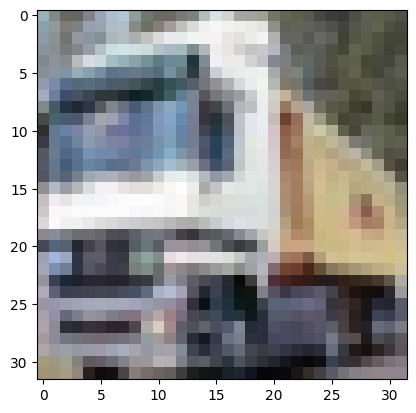

In [12]:
plt.imshow(image.permute(1,2,0))

In [13]:
train_data_loader=DataLoader(dataset=training_data,
                            batch_size=64,
                             shuffle=True
                             )

test_data_loader=DataLoader(dataset=test_data,
                            batch_size=64,
                            shuffle=False)

In [14]:
type(train_data_loader)

torch.utils.data.dataloader.DataLoader

In [15]:
train_data_loader.batch_size , len(train_data_loader)

(64, 782)

In [16]:
test_data_loader.batch_size , len(test_data_loader)

(64, 157)

In [17]:
torch.cuda.random.manual_seed(1)
torch.random.manual_seed(1)
class BasicBlock(nn.Module):
    expansion = 1 

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample 

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # Residual connection
        out = self.relu(out)

        return out


In [18]:
class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(CustomResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Output layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [19]:
def resnet34(num_classes=10):
    return CustomResNet(BasicBlock, [3, 4, 6, 3], num_classes)

model = resnet34()


In [20]:
# model=Model(640,30,len(training_data.classes))
model.to(device)

CustomResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [21]:
lossfn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.01,weight_decay=1e-5)

In [22]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
EPOCH=20
train_loss_values=[]
test_loss_values=[]
for epoch in tqdm(range(EPOCH)):
  #train loop
  train_loss=0
  for batch , (X,y) in enumerate(train_data_loader):
    X=X.to(device)
    y=y.to(device)
    y_pred=model(X)
    loss=lossfn(y_pred,y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss/=len(train_data_loader)
  train_loss_values.append(train_loss)
    
  #testing
  model.eval()
  test_loss=0
  test_accuracy = 0
  with  torch.inference_mode():
    for X_test,y_test in test_data_loader:
      X_test=X_test.to(device)
      y_test=y_test.to(device)
      y_pred_test=model(X_test)
      test_accuracy+= accuracy_fn(y_pred_test, y_test)
      test_loss+=lossfn(y_pred_test,y_test)


    test_accuracy/=len(test_data_loader)
    test_loss/= len(test_data_loader)
    test_loss_values.append(test_loss)
    print(f"Test loss values : {test_loss}")
print(f"test loss for each epoch = {test_loss_values}")
print(f"test Accuracy={test_accuracy}")
print(train_loss_values)

  0%|          | 0/20 [00:00<?, ?it/s]

Test loss values : 1.5731780529022217
Test loss values : 1.9345382452011108
Test loss values : 1.524091124534607
Test loss values : 1.355992317199707
Test loss values : 1.2545095682144165
Test loss values : 1.2205557823181152
Test loss values : 1.1713063716888428
Test loss values : 1.1190515756607056
Test loss values : 1.1411094665527344
Test loss values : 1.0981963872909546
Test loss values : 1.0385682582855225
Test loss values : 1.0697630643844604
Test loss values : 0.9807159304618835
Test loss values : 1.0618927478790283
Test loss values : 1.0482629537582397
Test loss values : 1.0851191282272339
Test loss values : 0.9662067294120789
Test loss values : 1.0072017908096313
Test loss values : 0.976856529712677
Test loss values : 1.0026049613952637
test loss for each epoch = [tensor(1.5732, device='cuda:0'), tensor(1.9345, device='cuda:0'), tensor(1.5241, device='cuda:0'), tensor(1.3560, device='cuda:0'), tensor(1.2545, device='cuda:0'), tensor(1.2206, device='cuda:0'), tensor(1.1713, de

In [23]:
a= np.arange(1,21)

In [24]:
type(test_loss_values)

list

In [25]:
type(train_loss_values[1])

torch.Tensor

In [26]:
train_loss_values_numpy= [ tensor.detach().cpu().numpy() for tensor in train_loss_values]

In [27]:
a_numpy=np.array(a)

In [28]:
test_loss_values_numpy= np.array([tensor.cpu().numpy() for tensor in test_loss_values])

In [29]:
test_loss_values_numpy

array([1.573178  , 1.9345382 , 1.5240911 , 1.3559923 , 1.2545096 ,
       1.2205558 , 1.1713064 , 1.1190516 , 1.1411095 , 1.0981964 ,
       1.0385683 , 1.0697631 , 0.98071593, 1.0618927 , 1.048263  ,
       1.0851191 , 0.9662067 , 1.0072018 , 0.9768565 , 1.002605  ],
      dtype=float32)

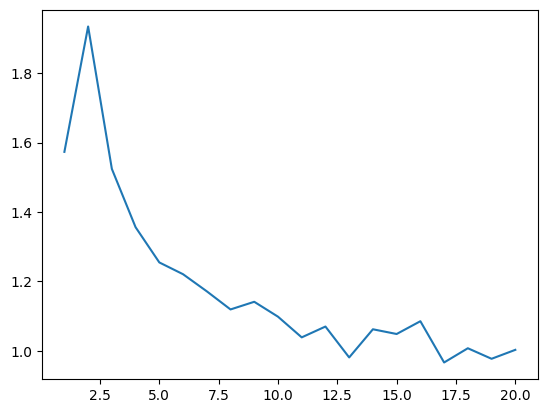

In [30]:
plt.plot(a_numpy, test_loss_values_numpy)

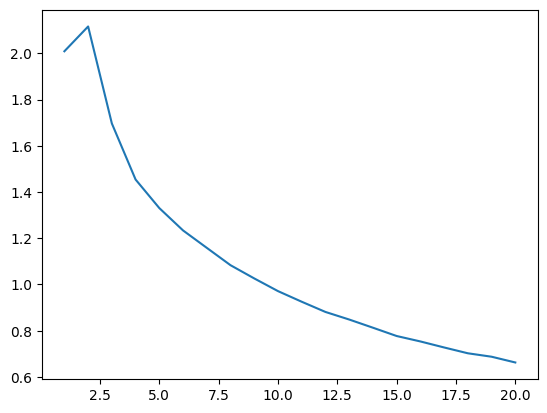

In [31]:
plt.plot(a_numpy, train_loss_values_numpy)